# **Plant Disease Prediction**

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
!pip install kaggle==1.5.12

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.0/59.0 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for kaggle: filename=kaggle-1.5.12-py3-none-any.whl size=73026 sha256=9ea5d9769686644ba6afe81c5607570872529262915b3a0f70b16868787c6166
  Stored in directory: /root/.cache/pip/wheels/f5/69/4d/d701fc604b9fb09be59718b4056fd5556a22588ce1f25dd090
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.7.4.5
    Uninstalling kaggle-1.7.4.5:
      Successfully uninstalled kaggle-1.7.4.5


In [6]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content'

In [7]:
!kaggle datasets download -d mohitsingh1804/plantvillage

 97% 795M/818M [00:04<00:00, 190MB/s]
100% 818M/818M [00:04<00:00, 193MB/s]


In [8]:
!unzip /content/plantvillage.zip

Streaming output truncated to the last 5000 lines.
  inflating: PlantVillage/val/Soybean___healthy/52c7d07b-561b-4380-801a-3824e65a5135___RS_HL 3797.JPG  
  inflating: PlantVillage/val/Soybean___healthy/53168d1c-ac90-4039-9eff-7479475a6b74___RS_HL 6355.JPG  
  inflating: PlantVillage/val/Soybean___healthy/5344b09f-bbbe-4a2c-9345-d93dd4e69eb4___RS_HL 4693.JPG  
  inflating: PlantVillage/val/Soybean___healthy/5361ba4a-351e-466c-99c5-8845f35c00df___RS_HL 2890.JPG  
  inflating: PlantVillage/val/Soybean___healthy/537e5409-d824-4859-967f-3c502f13deec___RS_HL 5474.JPG  
  inflating: PlantVillage/val/Soybean___healthy/538969da-545b-4bce-bc1d-0932898dc5e6___RS_HL 5230.JPG  
  inflating: PlantVillage/val/Soybean___healthy/538ccfe2-1509-40d7-beae-ae7cf84e1e5d___RS_HL 3717.JPG  
  inflating: PlantVillage/val/Soybean___healthy/5397bf6a-aeeb-4f1c-b554-bdb604bb23c3___RS_HL 6508.JPG  
  inflating: PlantVillage/val/Soybean___healthy/53dc0466-621c-43e1-9c5e-e340f3d50171___RS_HL 6381.JPG  
  inflating: 

## Importing Libraries

In [9]:
!pip install tensorflow

In [10]:
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.models import Model, save_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sb
from warnings import filterwarnings
filterwarnings('ignore')

## Reading and Processing Data

In [11]:
directory = "/content/PlantVillage/train"
IMG_SIZE = (224, 224)
NUM_CLASSES = 38
BATCH_SIZE = 16
EPOCHS = 10

In [12]:
# Load Dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
    directory,
    validation_split=0.1,
    subset="training",
    seed=42,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='int'
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    directory,
    validation_split=0.1,
    subset="validation",
    seed=42,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='int'
)

Found 43444 files belonging to 38 classes.
Using 39100 files for training.
Found 43444 files belonging to 38 classes.
Using 4344 files for validation.


In [13]:
# Saving class names
class_names = train_ds.class_names
np.save('class_names.npy', class_names)

In [14]:
class_names

['Apple___Apple_scab',
 'Apple___Black_rot',
 'Apple___Cedar_apple_rust',
 'Apple___healthy',
 'Blueberry___healthy',
 'Cherry_(including_sour)___Powdery_mildew',
 'Cherry_(including_sour)___healthy',
 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot',
 'Corn_(maize)___Common_rust_',
 'Corn_(maize)___Northern_Leaf_Blight',
 'Corn_(maize)___healthy',
 'Grape___Black_rot',
 'Grape___Esca_(Black_Measles)',
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
 'Grape___healthy',
 'Orange___Haunglongbing_(Citrus_greening)',
 'Peach___Bacterial_spot',
 'Peach___healthy',
 'Pepper,_bell___Bacterial_spot',
 'Pepper,_bell___healthy',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy',
 'Raspberry___healthy',
 'Soybean___healthy',
 'Squash___Powdery_mildew',
 'Strawberry___Leaf_scorch',
 'Strawberry___healthy',
 'Tomato___Bacterial_spot',
 'Tomato___Early_blight',
 'Tomato___Late_blight',
 'Tomato___Leaf_Mold',
 'Tomato___Septoria_leaf_spot',
 'Tomato___Spider_mites Two-spotted_

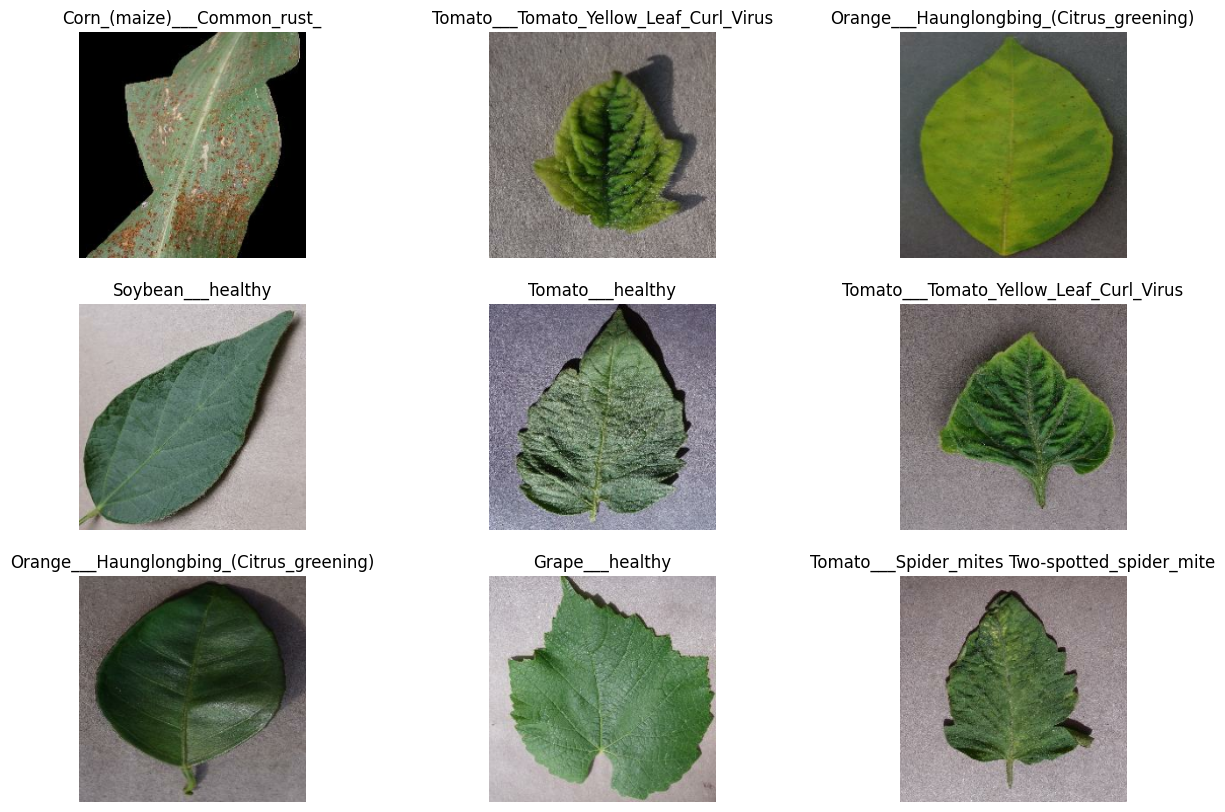

In [15]:
# to show images from dataset
plt.figure(figsize=(15, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [16]:
# Normalize & Prefetch
normalization_layer = keras.layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y)).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y)).prefetch(tf.data.AUTOTUNE)

##**Modelling**

## Using Pre-Trained ResNet50V2

In [17]:
# Model: ResNet50V2
base_model = keras.applications.ResNet50V2(
    weights='imagenet', include_top=False, input_shape=IMG_SIZE + (3,))

94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [18]:
# Freezing all layers except the last 50 to fine-tune the model for the specific task while retaining learned features.
base_model.trainable = True
for layer in base_model.layers[:-50]:
    layer.trainable = False

In [19]:
# base_model Summary
base_model.summary()


Model: "resnet50v2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_conv[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 56, 56,    │        256 │ pool1_pool[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 56, 56,    │          0 │ conv2_block1_pre… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,096 │ conv2_block1_pre… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_pad  │ (None, 58, 58,    │          0 │ conv2_block1_1_r… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_2_p… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_pre… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_out    │ (None, 56, 56,    │          0 │ conv2_block1_0_c

 Total params: 23,564,800 (89.89 MB)

 Trainable params: 16,352,256 (62.38 MB)

 Non-trainable params: 7,212,544 (27.51 MB)

In [20]:
model = keras.Sequential([
    keras.layers.Input(shape=IMG_SIZE + (3,)),
    keras.layers.RandomFlip(),
    keras.layers.RandomRotation(0.2),
    keras.layers.RandomZoom(0.1),
    keras.layers.Rescaling(1./255),
    base_model,
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [21]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [22]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_flip (RandomFlip)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation                 │ (None, 224, 224, 3)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom (RandomZoom)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50v2 (Functional)         │ (None, 7, 7, 2048)     │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 38)             │        77,862 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,642,662 (90.19 MB)

 Trainable params: 16,430,118 (62.68 MB)

 Non-trainable params: 7,212,544 (27.51 MB)

In [23]:
# Callbacks
callbacks = [
    ReduceLROnPlateau(patience=2, verbose=1),
    EarlyStopping(patience=5, restore_best_weights=True)
]

In [24]:
# Training
history = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS, callbacks=callbacks)

Epoch 1/10
2444/2444 ━━━━━━━━━━━━━━━━━━━━ 304s 117ms/step - accuracy: 0.3100 - loss: 2.5120 - val_accuracy: 0.3023 - val_loss: 3.1346 - learning_rate: 1.0000e-04
Epoch 2/10
2444/2444 ━━━━━━━━━━━━━━━━━━━━ 282s 115ms/step - accuracy: 0.4997 - loss: 1.6707 - val_accuracy: 0.2468 - val_loss: 4.7116 - learning_rate: 1.0000e-04
Epoch 3/10
2444/2444 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.5774 - loss: 1.4095
Epoch 3: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
2444/2444 ━━━━━━━━━━━━━━━━━━━━ 283s 116ms/step - accuracy: 0.5774 - loss: 1.4095 - val_accuracy: 0.1791 - val_loss: 6.8488 - learning_rate: 1.0000e-04
Epoch 4/10
2444/2444 ━━━━━━━━━━━━━━━━━━━━ 283s 116ms/step - accuracy: 0.6561 - loss: 1.1167 - val_accuracy: 0.6823 - val_loss: 0.9964 - learning_rate: 1.0000e-05
Epoch 5/10
2444/2444 ━━━━━━━━━━━━━━━━━━━━ 284s 116ms/step - accuracy: 0.6909 - loss: 0.9913 - val_accuracy: 0.6853 - val_loss: 0.9933 - learning_rate: 1.0000e-05
Epoch 6/10
2444/2444 ━━━━━━━━━━━━━━

## Model Evaluation

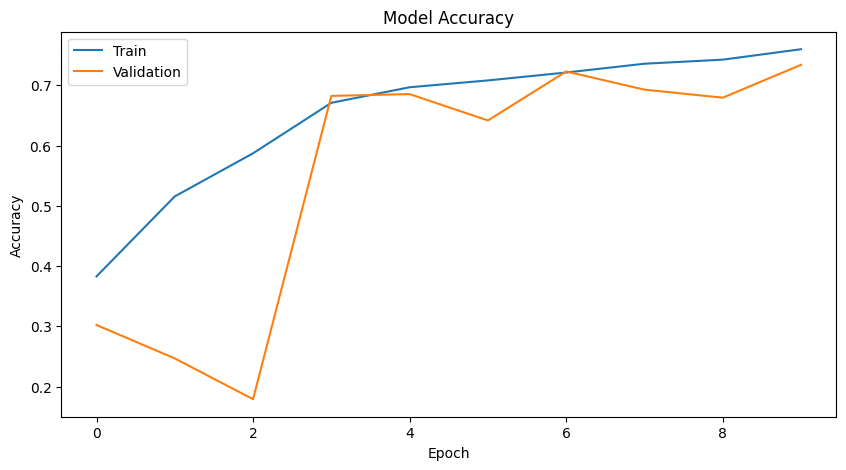

In [25]:
# Plot training & validation accuracy

plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Save the plot
plt.savefig('model_accuracy_plot.png', dpi=300)

plt.show()

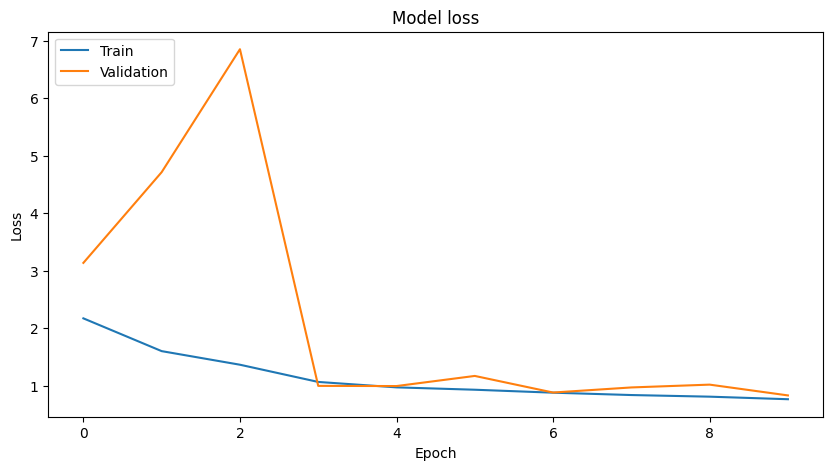

In [26]:
# Plot training & validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

#save the plot
plt.savefig('model_loss_plot.png', dpi=300)

plt.show()

### Training data

In [27]:
# Predict on training data
y_pred = model.predict(train_ds)
y_pred = np.argmax(y_pred, axis=1)

# Get true labels
y_true = []
for _, labels in train_ds:
    y_true.extend(labels.numpy())

# Classification report
print(classification_report(y_true, y_pred, target_names=class_names))

2444/2444 ━━━━━━━━━━━━━━━━━━━━ 146s 59ms/step
                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       0.00      0.00      0.00       453
                                 Apple___Black_rot       0.02      0.03      0.02       452
                          Apple___Cedar_apple_rust       0.00      0.00      0.00       190
                                   Apple___healthy       0.03      0.04      0.04      1178
                               Blueberry___healthy       0.03      0.04      0.03      1094
          Cherry_(including_sour)___Powdery_mildew       0.02      0.01      0.01       768
                 Cherry_(including_sour)___healthy       0.02      0.03      0.02       618
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.02      0.02      0.02       363
                       Corn_(maize)___Common_rust_       0.03      0.03      0.03       854
               Corn_(maize)___Nor

### Validation Data

In [ ]:
# Predict on validation data
y_pred = model.predict(val_ds)
y_pred = np.argmax(y_pred, axis=1)

# Get true labels
y_true = []
for _, labels in val_ds:
    y_true.extend(labels.numpy())

# Classification report
print(classification_report(y_true, y_pred, target_names=class_names))

In [ ]:
plt.figure(figsize=(12, 10))  # Slightly compact size for 3x3 grid

# Get predictions for the current batch of images
pred_labels = model.predict(images)
pred_labels = np.argmax(pred_labels, axis=1) # Get the class with highest probability

for i in range(9):
    img = images[i].numpy() * 255.0
    img = img.astype("uint8")

    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.title(f"True: {class_names[labels[i]]}\nPred: {class_names[pred_labels[i]]}", fontsize=9)
    plt.axis("off")

plt.tight_layout()
plt.show()

## Saving model

In [31]:
model.save("/content/model.keras")

# **UI using Gradio**

In [ ]:
!pip install gradio

In [33]:
import gradio as gr
import numpy as np
import tensorflow as tf

# Load the saved model
model = tf.keras.models.load_model("/content/model.keras")

# Load the class names
class_names = np.load('class_names.npy')

def predict_insect(image):
    """Predicts the class of the insect in the given image."""
    if image is None:
        return None

    # Preprocess the image
    img = tf.image.resize(image, (224, 224))
    img = tf.expand_dims(img, axis=0)
    img = img / 255.0  # Normalize

    # Make prediction
    predictions = model.predict(img)
    predicted_class_index = np.argmax(predictions, axis=1)[0]
    predicted_class_name = class_names[predicted_class_index]

    return predicted_class_name

# Create the Gradio interface
image_input = gr.Image(label="Upload Image")
output_text = gr.Textbox(label="Prediction")

interface = gr.Interface(
    fn=predict_insect,
    inputs=image_input,
    outputs=output_text,
    title="Plant disease Detection",
    description="Upload an image of a plant to detect diseases or if it's healthy."
)

# Launch the interface
interface.launch(debug=True)

It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://85063d022bfcc39aa4.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


ERROR:    Exception in ASGI application
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/uvicorn/protocols/http/h11_impl.py", line 403, in run_asgi
    result = await app(  # type: ignore[func-returns-value]
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/uvicorn/middleware/proxy_headers.py", line 60, in __call__
    return await self.app(scope, receive, send)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/fastapi/applications.py", line 1133, in __call__
    await super().__call__(scope, receive, send)
  File "/usr/local/lib/python3.12/dist-packages/starlette/applications.py", line 113, in __call__
    await self.middleware_stack(scope, receive, send)
  File "/usr/local/lib/python3.12/dist-packages/starlette/middleware/errors.py", line 186, in __call__
    raise exc
  File "/usr/local/lib/python3.12/dist-packages/starlette/middleware/errors.py",

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


ERROR:    Exception in ASGI application
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/uvicorn/protocols/http/h11_impl.py", line 403, in run_asgi
    result = await app(  # type: ignore[func-returns-value]
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/uvicorn/middleware/proxy_headers.py", line 60, in __call__
    return await self.app(scope, receive, send)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/fastapi/applications.py", line 1133, in __call__
    await super().__call__(scope, receive, send)
  File "/usr/local/lib/python3.12/dist-packages/starlette/applications.py", line 113, in __call__
    await self.middleware_stack(scope, receive, send)
  File "/usr/local/lib/python3.12/dist-packages/starlette/middleware/errors.py", line 186, in __call__
    raise exc
  File "/usr/local/lib/python3.12/dist-packages/starlette/middleware/errors.py",

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


ERROR:    Exception in ASGI application
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/uvicorn/protocols/http/h11_impl.py", line 403, in run_asgi
    result = await app(  # type: ignore[func-returns-value]
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/uvicorn/middleware/proxy_headers.py", line 60, in __call__
    return await self.app(scope, receive, send)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/fastapi/applications.py", line 1133, in __call__
    await super().__call__(scope, receive, send)
  File "/usr/local/lib/python3.12/dist-packages/starlette/applications.py", line 113, in __call__
    await self.middleware_stack(scope, receive, send)
  File "/usr/local/lib/python3.12/dist-packages/starlette/middleware/errors.py", line 186, in __call__
    raise exc
  File "/usr/local/lib/python3.12/dist-packages/starlette/middleware/errors.py",

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://85063d022bfcc39aa4.gradio.live
